# Forecasting Basics - Financial Statement Model

This notebook demonstrates the basic usage of the forecasting sub-module in the `fin_statement_model` library. The forecasting module provides flexible methods for projecting financial statement values into future periods.

## Topics Covered:
1. Setting up a financial statement graph with historical data
2. Non-mutating forecasts using `forecast_value()`
3. Multiple node forecasting with `forecast_multiple()`
4. Mutating forecasts with `create_forecast()`
5. Different forecast methods:
   - **Simple**: Constant growth rate
   - **Curve**: Period-specific growth rates
   - **Statistical**: Distribution-based growth
   - **Average**: Historical average
   - **Historical Growth**: Average of historical growth rates

## Key Concepts:
- **Mutating vs Non-mutating**: Mutating operations modify the graph, non-mutating return values only
- **Forecast Methods**: Different approaches to projecting values
- **Forecast Configurations**: Method-specific parameters for customization


## 1. Setup and Imports


In [1]:
# Standard library imports
import logging

# Data manipulation and visualization
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# fin_statement_model imports
from fin_statement_model.core.graph import Graph
from fin_statement_model.forecasting import StatementForecaster

# Set up logging to see what's happening
logging.basicConfig(level=logging.INFO, format='%(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)
logging.getLogger('fin_statement_model.forecasting.period_manager').setLevel(logging.ERROR)

# Configure matplotlib - use a style that's always available
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except Exception:
    # Fallback to a basic style if seaborn is not available
    plt.style.use('ggplot')
    
plt.rcParams['figure.figsize'] = (12, 6)


## 2. Create a Sample Financial Statement Graph

First, let's create a financial statement graph with some historical data. We'll simulate a simple company with revenue, costs, and net income over 4 historical years.


In [2]:
# Create a financial statement graph
fsg = Graph()

# Define historical periods
historical_periods = ["2020", "2021", "2022", "2023"]
fsg.add_periods(historical_periods)

# Create some nodes with historical data
# Revenue node with 10% annual growth trend
revenue_values = {"2020": 1000.0, "2021": 1100.0, "2022": 1210.0, "2023": 1331.0}
fsg.add_financial_statement_item("revenue", revenue_values)

# Cost of Goods Sold (COGS) as 60% of revenue
cogs_values = {"2020": 600.0, "2021": 660.0, "2022": 726.0, "2023": 798.6}
fsg.add_financial_statement_item("cogs", cogs_values)

# Operating expenses with 5% annual growth
opex_values = {"2020": 200.0, "2021": 210.0, "2022": 220.5, "2023": 231.5}
fsg.add_financial_statement_item("operating_expenses", opex_values)

# Add a calculation node for net income
fsg.add_calculation(
    name="net_income",
    input_names=["revenue", "cogs", "operating_expenses"],
    #formula_variable_names=["rev", "cost", "opex"],   
    operation_type="formula",
    formula="revenue - cogs - operating_expenses",
)

print("Historical data loaded:")
print("\nGraph structure:")
print(f"Periods: {fsg.periods}")
print(f"Nodes: {list(fsg.nodes.keys())}")

# Display historical values
df_historical = pd.DataFrame({
    node_name: {
        period: fsg.calculate(node_name, period) 
        for period in historical_periods
    }
    for node_name in ["revenue", "cogs", "operating_expenses", "net_income"]
})
print("\nHistorical Financial Data:")
print(df_historical.round(2))


Historical data loaded:

Graph structure:
Periods: ['2020', '2021', '2022', '2023']
Nodes: ['revenue', 'cogs', 'operating_expenses', 'net_income']

Historical Financial Data:
      revenue   cogs  operating_expenses  net_income
2020   1000.0  600.0               200.0       200.0
2021   1100.0  660.0               210.0       230.0
2022   1210.0  726.0               220.5       263.5
2023   1331.0  798.6               231.5       300.9


## 3. Non-Mutating Forecasts (forecast_value)

Non-mutating forecasts return forecast values without modifying the graph. This is useful for "what-if" analysis or when you want to compare different forecast scenarios.

### 3.1 Simple Forecast Method
The simple method applies a constant growth rate to all forecast periods.


In [3]:
# Create a forecaster instance
forecaster = StatementForecaster(fsg)

# Define forecast periods
forecast_periods = ["2024", "2025", "2026"]

# Simple forecast with 10% growth rate
simple_config = {"method": "simple", "config": 0.10}  # 10% growth

revenue_forecast = forecaster.forecast_value(
    node_name="revenue",
    forecast_periods=forecast_periods,
    forecast_config=simple_config
)

print("Revenue forecast with 10% constant growth:")
for period, value in revenue_forecast.items():
    print(f"  {period}: ${value:,.2f}")
    
# Calculate the implied growth rate
last_historical = fsg.calculate("revenue", "2023")
first_forecast = revenue_forecast["2024"]
implied_growth = ((first_forecast / last_historical) - 1) * 100
print(f"\nImplied growth from 2023 to 2024: {implied_growth:.1f}%")


Revenue forecast with 10% constant growth:
  2024: $1,464.10
  2025: $1,610.51
  2026: $1,771.56

Implied growth from 2023 to 2024: 10.0%


### 3.2 Curve Forecast Method
The curve method allows you to specify different growth rates for each forecast period, useful for modeling declining growth rates or seasonal patterns.


In [4]:
# Curve forecast with declining growth rates
curve_config = {
    "method": "curve", 
    "config": [0.08, 0.06, 0.04]  # 8%, 6%, 4% growth for each year
}

revenue_curve_forecast = forecaster.forecast_value(
    node_name="revenue",
    forecast_periods=forecast_periods,
    forecast_config=curve_config
)

print("Revenue forecast with declining growth rates:")
for i, (period, value) in enumerate(revenue_curve_forecast.items()):
    growth_rate = curve_config["config"][i] * 100
    print(f"  {period}: ${value:,.2f} (growth: {growth_rate:.0f}%)")
    
# Compare simple vs curve forecasts
print("\nComparison of forecast methods:")
comparison_df = pd.DataFrame({
    'Simple (10%)': revenue_forecast,
    'Curve (8%, 6%, 4%)': revenue_curve_forecast
})
print(comparison_df.round(2))


Revenue forecast with declining growth rates:
  2024: $1,437.48 (growth: 8%)
  2025: $1,523.73 (growth: 6%)
  2026: $1,584.68 (growth: 4%)

Comparison of forecast methods:
      Simple (10%)  Curve (8%, 6%, 4%)
2024       1464.10             1437.48
2025       1610.51             1523.73
2026       1771.56             1584.68


### 3.3 Average Forecast Method
The average method projects the historical average value forward.


In [5]:
# Average forecast - uses the historical average
average_config = {"method": "average", "config": None}

revenue_average_forecast = forecaster.forecast_value(
    node_name="revenue",
    forecast_periods=forecast_periods,
    forecast_config=average_config
)

# Calculate historical average for comparison
historical_values = [revenue_values[p] for p in historical_periods]
historical_avg = sum(historical_values) / len(historical_values)

print(f"Historical average revenue: ${historical_avg:,.2f}")
print("\nRevenue forecast using historical average:")
for period, value in revenue_average_forecast.items():
    print(f"  {period}: ${value:,.2f}")


Historical average revenue: $1,160.25

Revenue forecast using historical average:
  2024: $1,160.25
  2025: $1,160.25
  2026: $1,160.25


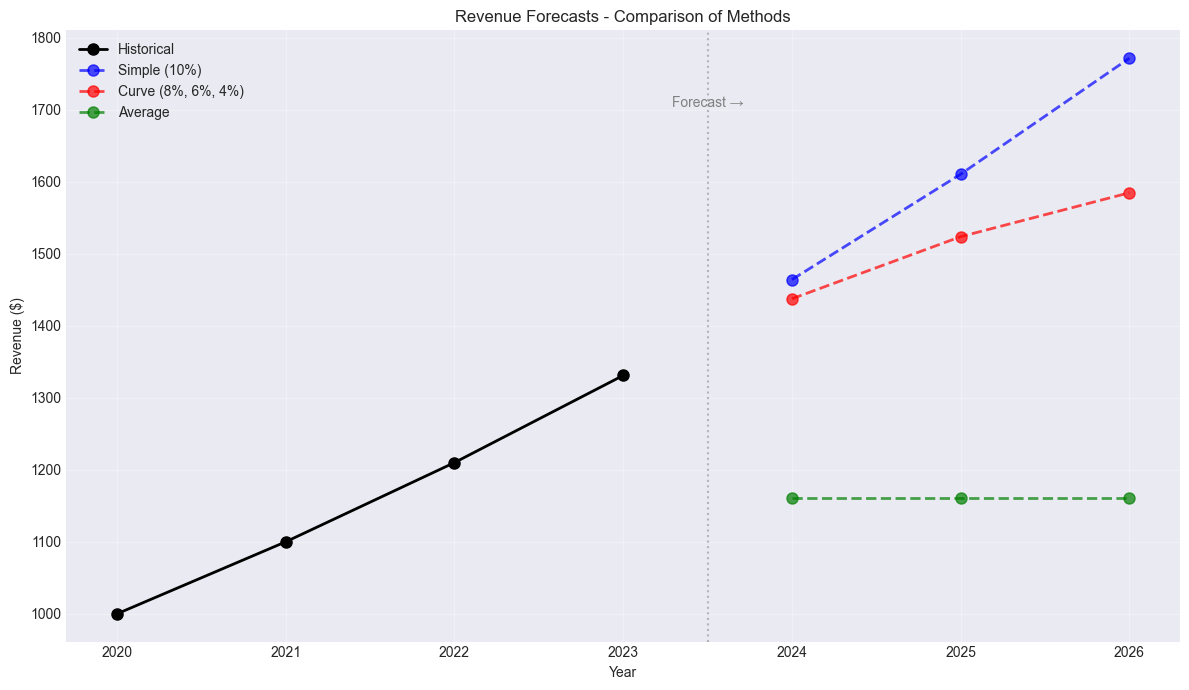

In [6]:
# Visualize different forecast methods
fig, ax = plt.subplots(figsize=(12, 7))

# Historical data
historical_x = list(range(len(historical_periods)))
historical_y = [revenue_values[p] for p in historical_periods]
ax.plot(historical_x, historical_y, 'ko-', label='Historical', linewidth=2, markersize=8)

# Forecast data
forecast_x = list(range(len(historical_periods), len(historical_periods) + len(forecast_periods)))

# Simple forecast
simple_y = [revenue_forecast[p] for p in forecast_periods]
ax.plot(forecast_x, simple_y, 'bo--', label='Simple (10%)', linewidth=2, markersize=8, alpha=0.7)

# Curve forecast
curve_y = [revenue_curve_forecast[p] for p in forecast_periods]
ax.plot(forecast_x, curve_y, 'ro--', label='Curve (8%, 6%, 4%)', linewidth=2, markersize=8, alpha=0.7)

# Average forecast
average_y = [revenue_average_forecast[p] for p in forecast_periods]
ax.plot(forecast_x, average_y, 'go--', label='Average', linewidth=2, markersize=8, alpha=0.7)

# Formatting
all_periods = historical_periods + forecast_periods
ax.set_xticks(range(len(all_periods)))
ax.set_xticklabels(all_periods)
ax.axvline(x=len(historical_periods)-0.5, color='gray', linestyle=':', alpha=0.5)
ax.text(len(historical_periods)-0.5, ax.get_ylim()[1]*0.95, 'Forecast →', ha='center', va='top', fontsize=10, color='gray')
ax.set_xlabel('Year')
ax.set_ylabel('Revenue ($)')
ax.set_title('Revenue Forecasts - Comparison of Methods')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### 3.4 Historical Growth Method
This method calculates the average historical growth rate and applies it to future periods.


In [7]:
# Historical growth forecast
hist_growth_config = {"method": "historical_growth", "config": None}

revenue_hist_growth_forecast = forecaster.forecast_value(
    node_name="revenue",
    forecast_periods=forecast_periods,
    forecast_config=hist_growth_config
)

# Calculate actual historical growth rates for comparison
historical_growth_rates = []
for i in range(1, len(historical_periods)):
    prev_val = revenue_values[historical_periods[i-1]]
    curr_val = revenue_values[historical_periods[i]]
    growth = ((curr_val / prev_val) - 1) * 100
    historical_growth_rates.append(growth)
    
avg_historical_growth = sum(historical_growth_rates) / len(historical_growth_rates)

print(f"Historical growth rates: {[f'{g:.1f}%' for g in historical_growth_rates]}")
print(f"Average historical growth: {avg_historical_growth:.1f}%")
print("\nRevenue forecast using average historical growth:")
for period, value in revenue_hist_growth_forecast.items():
    print(f"  {period}: ${value:,.2f}")


Historical growth rates: ['10.0%', '10.0%', '10.0%']
Average historical growth: 10.0%

Revenue forecast using average historical growth:
  2024: $1,464.10
  2025: $1,610.51
  2026: $1,771.56


### 3.5 Statistical Forecast Method
The statistical method draws growth rates from probability distributions, useful for Monte Carlo simulations and scenario analysis.


In [8]:
# Statistical forecast with normal distribution
# Mean growth of 10% with 3% standard deviation
statistical_config = {
    "method": "statistical",
    "config": {
        "distribution": "normal",
        "params": {"mean": 0.10, "std": 0.03}
    }
}

# Run multiple simulations to show variability
print("Statistical forecasts (5 simulations):")
simulations = []
for i in range(5):
    stat_forecast = forecaster.forecast_value(
        node_name="revenue",
        forecast_periods=forecast_periods,
        forecast_config=statistical_config
    )
    simulations.append(stat_forecast)
    print(f"\nSimulation {i+1}:")
    for period, value in stat_forecast.items():
        print(f"  {period}: ${value:,.2f}")

# Calculate statistics across simulations
print("\nStatistics across simulations:")
for period in forecast_periods:
    values = [sim[period] for sim in simulations]
    mean_val = sum(values) / len(values)
    std_val = np.std(values)
    print(f"{period}: Mean ${mean_val:,.2f}, Std ${std_val:,.2f}")


Statistical forecasts (5 simulations):

Simulation 1:
  2024: $1,480.19
  2025: $1,542.98
  2026: $1,628.25

Simulation 2:
  2024: $1,507.88
  2025: $1,656.38
  2026: $1,847.67

Simulation 3:
  2024: $1,437.57
  2025: $1,580.43
  2026: $1,831.33

Simulation 4:
  2024: $1,550.32
  2025: $1,733.23
  2026: $1,911.05

Simulation 5:
  2024: $1,495.45
  2025: $1,680.31
  2026: $1,842.57

Statistics across simulations:
2024: Mean $1,494.28, Std $36.72
2025: Mean $1,638.67, Std $68.61
2026: Mean $1,812.17, Std $96.08


In [9]:
# Statistical forecast with uniform distribution
# Growth between 5% and 15%
uniform_config = {
    "method": "statistical",
    "config": {
        "distribution": "uniform",
        "params": {"low": 0.05, "high": 0.15}
    }
}

uniform_forecast = forecaster.forecast_value(
    node_name="revenue",
    forecast_periods=forecast_periods,
    forecast_config=uniform_config
)

print("Revenue forecast with uniform distribution (5%-15% growth):")
for period, value in uniform_forecast.items():
    print(f"  {period}: ${value:,.2f}")


Revenue forecast with uniform distribution (5%-15% growth):
  2024: $1,415.59
  2025: $1,550.43
  2026: $1,708.89


## 4. Multiple Node Forecasting (forecast_multiple)

The `forecast_multiple` method allows you to forecast multiple nodes at once, each with its own forecast configuration. This returns ForecastResult objects with additional metadata.


In [10]:
# Forecast multiple nodes with different methods
node_configs = {
    "revenue": {"method": "simple", "config": 0.08},  # 8% growth
    "cogs": {"method": "curve", "config": [0.06, 0.05, 0.04]},  # Declining growth
    "operating_expenses": {"method": "average", "config": None}  # Historical average
}

# Forecast multiple nodes at once
multi_results = forecaster.forecast_multiple(
    node_names=["revenue", "cogs", "operating_expenses"],
    forecast_periods=forecast_periods,
    forecast_configs=node_configs
)

# Display results
print("Multiple node forecasting results:\n")
for node_name, result in multi_results.items():
    print(node_name.upper() + ":")
    print(f"  Method: {result.method}")
    print("  Values:")
    for period, value in result.values.items():
        print(f"    {period}: ${value:,.2f}")
    print()

# summary DataFrame: columns = nodes, rows = forecast periods
forecast_summary = pd.DataFrame({
    node_name: result.values
    for node_name, result in multi_results.items()
})

# ── net-income row ───────────────────────────────────────────────
forecast_summary.loc['net_income'] = (
    forecast_summary['revenue']
    - forecast_summary['cogs']
    - forecast_summary['operating_expenses']
)

print("Forecast Summary:")
print(forecast_summary.round(2))

# ── margins ──────────────────────────────────────────────────────
gross_margin = (
    (forecast_summary['revenue'] - forecast_summary['cogs'])
    / forecast_summary['revenue'] * 100
)
net_margin = forecast_summary.loc['net_income'] / forecast_summary['revenue'] * 100

margin_df = pd.DataFrame({
    'Gross Margin %': gross_margin,
    'Net Margin %': net_margin
})
print("\nImplied Margins:")
print(margin_df.round(1))


Multiple node forecasting results:

REVENUE:
  Method: simple
  Values:
    2024: $1,437.48
    2025: $1,552.48
    2026: $1,676.68

COGS:
  Method: curve
  Values:
    2024: $846.52
    2025: $888.84
    2026: $924.40

OPERATING_EXPENSES:
  Method: average
  Values:
    2024: $215.50
    2025: $215.50
    2026: $215.50

Forecast Summary:
            revenue    cogs  operating_expenses
2024        1437.48  846.52               215.5
2025        1552.48  888.84               215.5
2026        1676.68  924.40               215.5
net_income      NaN     NaN                 NaN

Implied Margins:
                    Gross Margin %  Net Margin %
2024                          41.1           NaN
2025                          42.7           NaN
2026                          44.9           NaN
cogs                           NaN           NaN
net_income                     NaN           NaN
operating_expenses             NaN           NaN
revenue                        NaN           NaN


## 5. Mutating Forecasts (create_forecast)

The `create_forecast` method modifies the graph by adding forecast periods and updating node values. This is useful when you want to persist the forecast results in the graph for further analysis or reporting.


In [11]:
# Check current periods in the graph
print("Periods before forecast:", fsg.periods)
print("Number of nodes:", len(fsg.nodes))

# Define node configurations for mutating forecast
mutating_configs = {
    "revenue": {"method": "simple", "config": 0.07},  # 7% growth
    "cogs": {"method": "simple", "config": 0.065},   # 6.5% growth  
    "operating_expenses": {"method": "simple", "config": 0.04}  # 4% growth
}

# Create the forecast - this modifies the graph!
forecaster.create_forecast(
    forecast_periods=forecast_periods,
    node_configs=mutating_configs
)

print("\nAfter creating forecast:")
print("Periods in graph:", fsg.periods)

# The net_income calculation node will automatically use the new forecast values
print("\nForecast values now in the graph:")
forecast_df = pd.DataFrame({
    node_name: {
        period: fsg.calculate(node_name, period)
        for period in forecast_periods
    }
    for node_name in ["revenue", "cogs", "operating_expenses", "net_income"]
})
print(forecast_df.round(2))


Periods before forecast: ['2020', '2021', '2022', '2023']
Number of nodes: 4

After creating forecast:
Periods in graph: ['2020', '2021', '2022', '2023', '2024', '2025', '2026']

Forecast values now in the graph:
      revenue    cogs  operating_expenses  net_income
2024  1424.17  850.51              240.76      332.90
2025  1523.86  905.79              250.39      367.68
2026  1630.53  964.67              260.41      405.46


matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

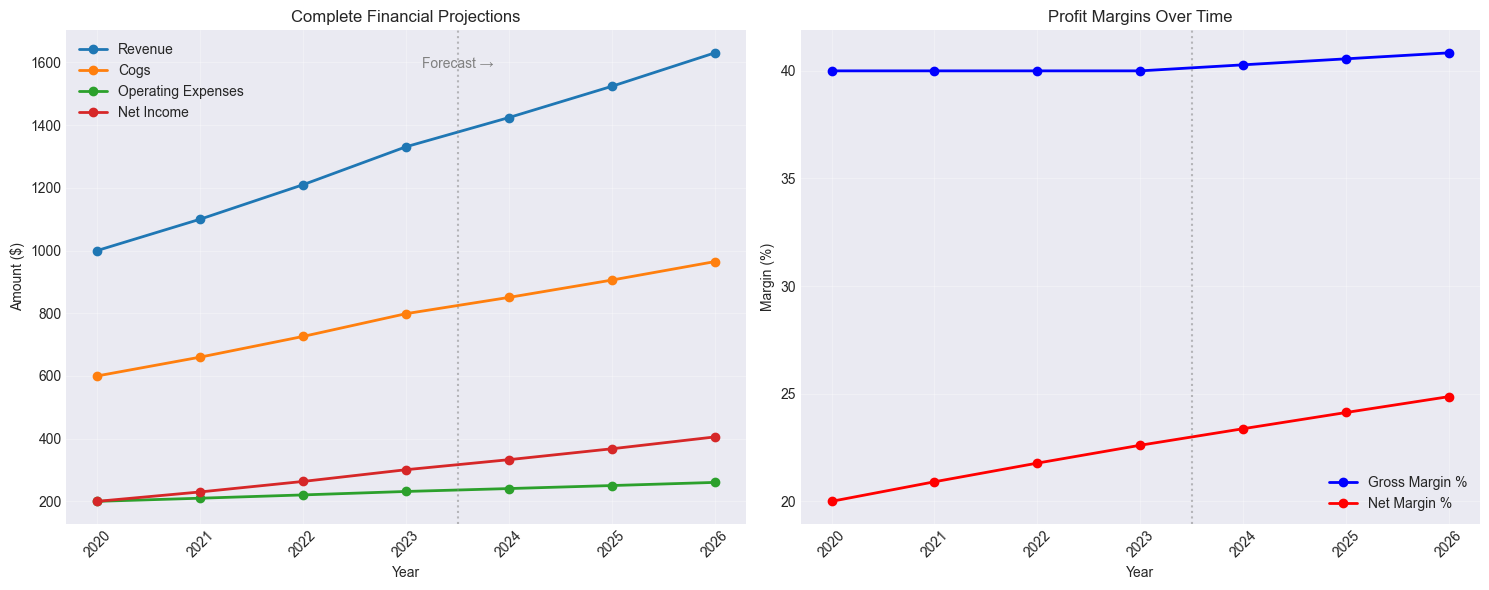


Forecast Period Summary:
Average growth rates in forecast period:
  revenue: 7.0%
  cogs: 6.5%
  operating_expenses: 4.0%


In [12]:
# Create a complete DataFrame with historical and forecast data
complete_df = pd.DataFrame({
    node_name: {
        period: fsg.calculate(node_name, period)
        for period in fsg.periods
    }
    for node_name in ["revenue", "cogs", "operating_expenses", "net_income"]
})

# Visualize the complete data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot absolute values
for node_name in ["revenue", "cogs", "operating_expenses", "net_income"]:
    values = [complete_df.loc[period, node_name] for period in fsg.periods]
    ax1.plot(fsg.periods, values, 'o-', label=node_name.replace('_', ' ').title(), linewidth=2, markersize=6)

# Add vertical line to separate historical and forecast
historical_end_idx = len(historical_periods) - 0.5
ax1.axvline(x=historical_end_idx, color='gray', linestyle=':', alpha=0.5)
ax1.text(historical_end_idx, ax1.get_ylim()[1]*0.95, 'Forecast →', ha='center', va='top', fontsize=10, color='gray')
ax1.set_xlabel('Year')
ax1.set_ylabel('Amount ($)')
ax1.set_title('Complete Financial Projections')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Plot margins over time
gross_margins = []
net_margins = []
for period in fsg.periods:
    revenue     = complete_df.loc[period, 'revenue']
    cogs        = complete_df.loc[period, 'cogs']
    net_income  = complete_df.loc[period, 'net_income']
    
    gross_margin = ((revenue - cogs) / revenue) * 100
    net_margin = (net_income / revenue) * 100
    
    gross_margins.append(gross_margin)
    net_margins.append(net_margin)

ax2.plot(fsg.periods, gross_margins, 'bo-', label='Gross Margin %', linewidth=2, markersize=6)
ax2.plot(fsg.periods, net_margins, 'ro-', label='Net Margin %', linewidth=2, markersize=6)
ax2.axvline(x=historical_end_idx, color='gray', linestyle=':', alpha=0.5)
ax2.set_xlabel('Year')
ax2.set_ylabel('Margin (%)')
ax2.set_title('Profit Margins Over Time')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Summary statistics
print("\nForecast Period Summary:")
print("Average growth rates in forecast period:")
for node_name in ["revenue", "cogs", "operating_expenses"]:
    historical_last = complete_df.loc["2023",node_name]
    forecast_first = complete_df.loc["2024",node_name]
    growth = ((forecast_first / historical_last) - 1) * 100
    print(f"  {node_name}: {growth:.1f}%")


## Summary

In this notebook, we've explored the forecasting capabilities of the `fin_statement_model` library:

### Key Takeaways:

1. **Two Types of Operations**:
   - **Non-mutating** (`forecast_value`, `forecast_multiple`): Return forecast values without modifying the graph
   - **Mutating** (`create_forecast`): Modify the graph by adding forecast periods and values

2. **Forecast Methods**:
   - **Simple**: Constant growth rate across all periods
   - **Curve**: Period-specific growth rates for more nuanced projections
   - **Average**: Projects historical average forward
   - **Historical Growth**: Uses average of historical growth rates
   - **Statistical**: Draws from probability distributions for uncertainty modeling

3. **Use Cases**:
   - **What-if Analysis**: Use non-mutating methods to test different scenarios
   - **Model Building**: Use mutating methods to build complete financial models
   - **Monte Carlo Simulation**: Use statistical methods for risk analysis
   - **Sensitivity Analysis**: Compare different forecast methods and parameters

### Next Steps:
- Explore custom forecast methods by extending `BaseForecastMethod`
- Integrate forecasts with statement formatting and reporting
- Use adjustments to override forecast values for specific scenarios
- Build more complex models with interdependent forecasts
